# Cat vs Dogs classifier w/ Data Augmentation

## Importing required modules

In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from jupyterthemes import jtplot
jtplot.style(theme='onedork', figsize=(16,9))

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Importing Data 

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)

In [3]:
zip_dir_base = os.path.dirname(zip_dir)
print(zip_dir_base)
!tree $zip_dir_base

C:\Users\Arunabh\.keras\datasets
Folder PATH listing for volume Windows
Volume serial number is 000000F2 929F:B39D
C:\USERS\ARUNABH\.KERAS\DATASETS
����cats_and_dogs_filtered
    ����train
    �   ����cats
    �   ����dogs
    ����validation
        ����cats
        ����dogs


In [4]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Analysing the data

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images    :', num_cats_tr)
print('total training dog images    :', num_dogs_tr)

print('total validation cat images  :', num_cats_val)
print('total validation dog images  :', num_dogs_val)
print('--')
print('total training images        :', total_train)
print('total validation images      :', total_val)


total training cat images    : 1000
total training dog images    : 1000
total validation cat images  : 500
total validation dog images  : 500
--
total training images        : 2000
total validation images      : 1000


## Data preparation

In [6]:
BATCH_SIZE = 100
IMG_SHAPE = 150

### Data Augmentation

In [12]:
def plotImages(images_arr):

    """Plot images in a 1x5 grid"""

    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.grid(False)
    plt.tight_layout()
    plt.show()

#### Horizontal flip

In [8]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


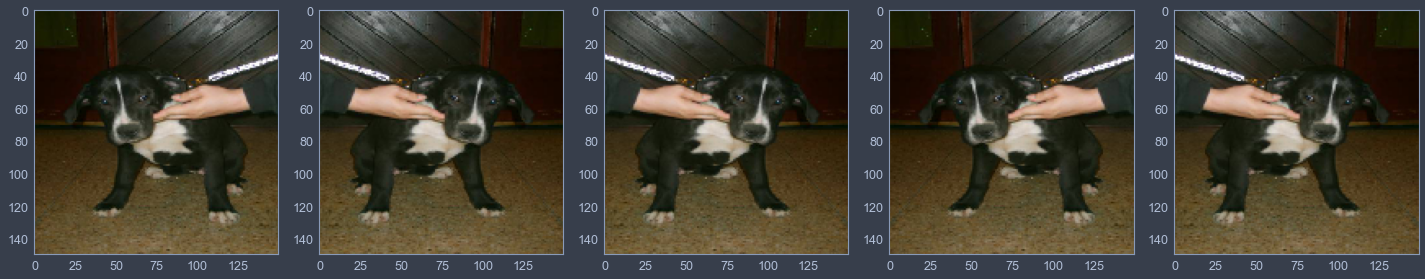

In [13]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Rotation

In [14]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


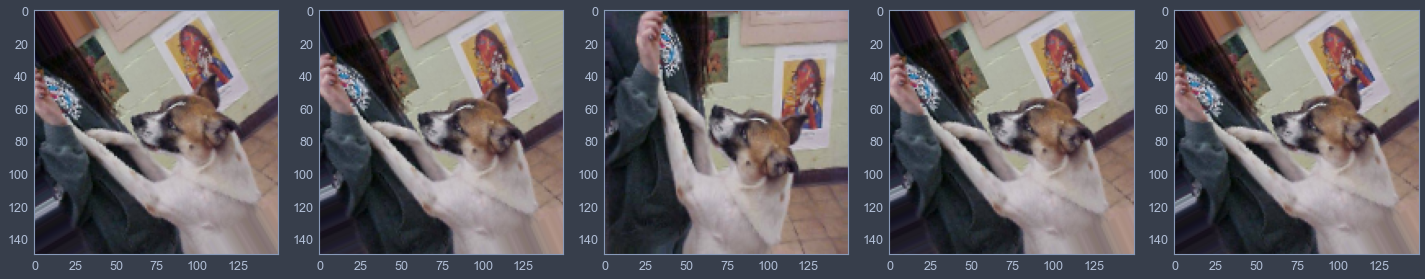

In [15]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Zoom

In [16]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


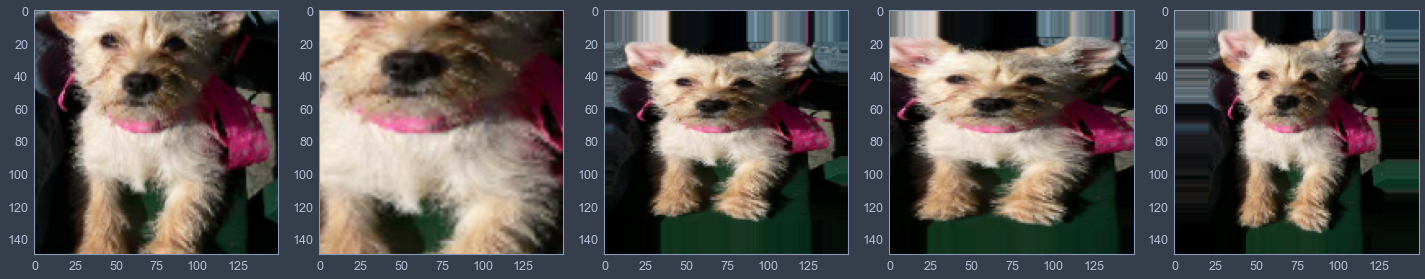

In [17]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Combining together

In [25]:
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory=train_dir,
                                                    shuffle=True,
                                                    target_size=(IMG_SHAPE, IMG_SHAPE),
                                                    class_mode='binary')

Found 2000 images belonging to 2 classes.


### Validation Data Generator

This will not have any image augmentation

In [19]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                directory=validation_dir,
                                                target_size=(IMG_SHAPE, IMG_SHAPE),
                                                class_mode='binary')

Found 1000 images belonging to 2 classes.


## Building the model

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [30]:
epochs=30
history = model.fit(
            train_data_gen,
            steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
            epochs=epochs,
            validation_data=val_data_gen,
            validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/30
20/20 [==============================] - 42s 2s/step - loss: 0.7402 - accuracy: 0.4965 - val_loss: 0.6909 - val_accuracy: 0.5100
Epoch 2/30
20/20 [==============================] - 32s 2s/step - loss: 0.6897 - accuracy: 0.5380 - val_loss: 0.6881 - val_accuracy: 0.5470
Epoch 3/30
20/20 [==============================] - 32s 2s/step - loss: 0.6864 - accuracy: 0.5350 - val_loss: 0.6624 - val_accuracy: 0.6030
Epoch 4/30
20/20 [==============================] - 32s 2s/step - loss: 0.6761 - accuracy: 0.5770 - val_loss: 0.6442 - val_accuracy: 0.6520
Epoch 5/30
20/20 [==============================] - 32s 2s/step - loss: 0.6615 - accuracy: 0.5990 - val_loss: 0.6396 - val_accuracy: 0.6290
Epoch 6/30
20/20 [==============================] - 32s 2s/step - loss: 0.6682 - accuracy: 0.5965 - val_loss: 0.6574 - val_accuracy: 0.6120
Epoch 7/30
20/20 [==============================] - 32s 2s/step - loss: 0.6617 - accuracy: 0.6065 - val_loss: 0.6321 - val_accuracy: 0.6370
Epoch 8/30
20/20 [==

Text(0.5, 1.0, 'Training and Validation Loss')

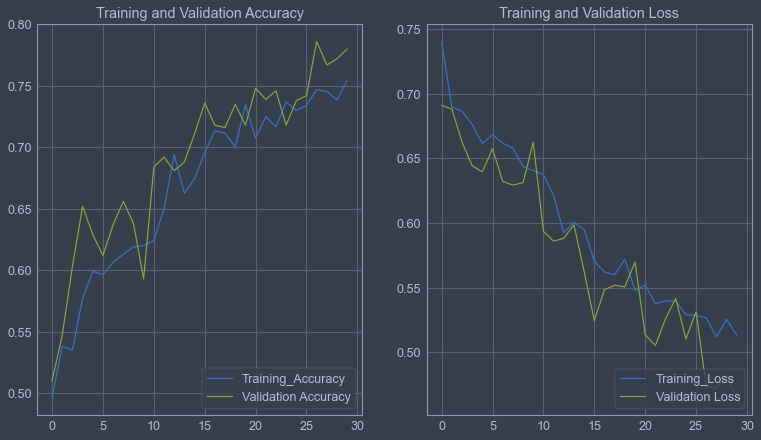

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training_Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy' )
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training_Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss' )
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')